In [1]:
### import libraries

# for DL modeling
import torch
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


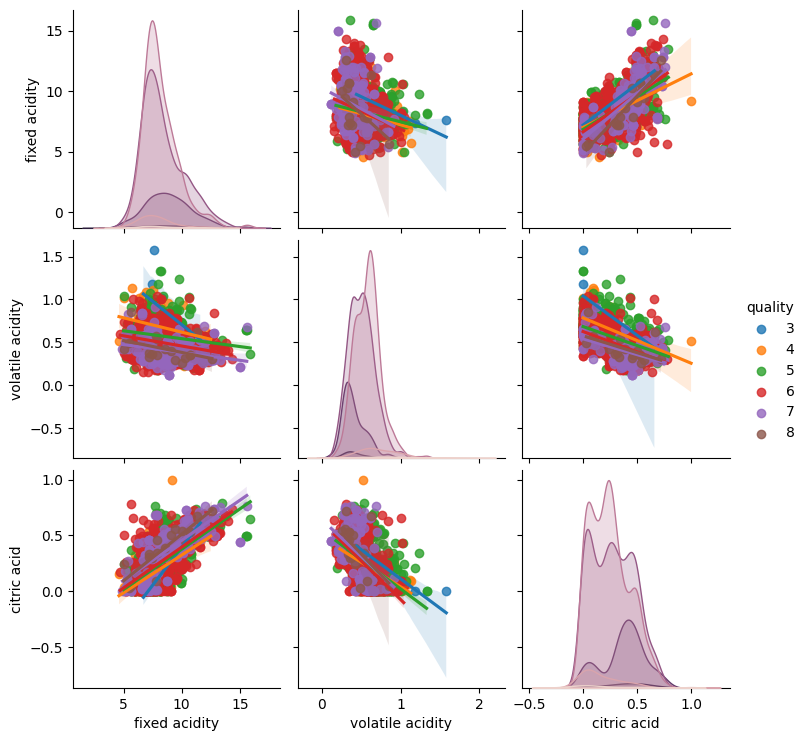

In [5]:
# pairwise plots
cols2plot = ['fixed acidity','volatile acidity','citric acid','quality']
sns.pairplot(data[cols2plot],kind='reg',hue='quality')
plt.show()

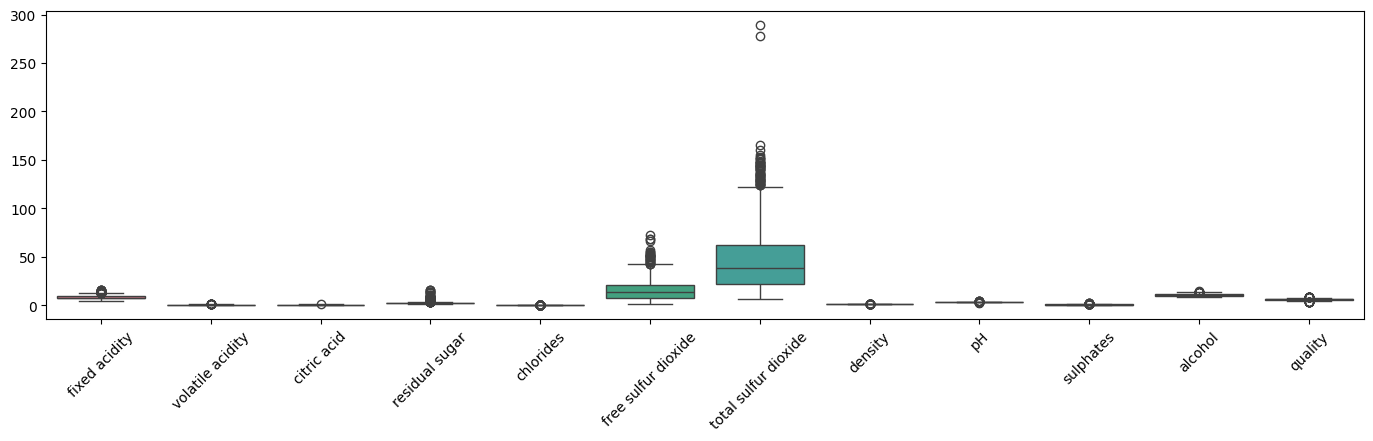

In [6]:
# plot some data
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)

# Get current tick locations and set both ticks and labels
current_ticks = ax.get_xticks()
ax.set_xticks(current_ticks)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show();


# remove rows with outliers
data = data[data['total sulfur dioxide']<200]

In [7]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
data = data.copy()

cols2zscore = data.columns
cols2zscore = cols2zscore.drop('quality')

# Noramlize the dataset
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# data = (
#     data
#     .assign(**{col: lambda d, c=col: stats.zscore(d[col])
#                for col in data.columns.drop('quality')})
# )

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000
mean,3.559388e-17,1.245786e-16,1.779694e-17,-9.788316e-17,-1.423755e-16,8.898469e-18,-5.339081e-17,-8.361001e-14,3.025479e-16,8.898469e-17,-5.695020e-16,5.634314
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,0.806630
min,-2.136087e+00,-2.280762e+00,-1.391823e+00,-1.169149e+00,-1.604575e+00,-1.422837e+00,-1.262581e+00,-3.546932e+00,-3.709380e+00,-1.937318e+00,-1.899221e+00,3.000000
25%,-7.006076e-01,-7.718255e-01,-9.286769e-01,-4.525789e-01,-3.721412e-01,-8.478700e-01,-7.596977e-01,-6.111392e-01,-6.587444e-01,-6.392206e-01,-8.653154e-01,5.000000
50%,-2.412541e-01,-4.530063e-02,-5.384522e-02,-2.376079e-01,-1.809014e-01,-1.770746e-01,-2.568145e-01,-6.216372e-04,-9.673073e-03,-2.261897e-01,-2.073755e-01,6.000000
75%,5.051954e-01,6.253377e-01,7.695258e-01,4.902022e-02,5.283609e-02,4.937208e-01,4.975104e-01,5.780428e-01,5.744912e-01,4.228588e-01,6.385471e-01,6.000000
max,4.352281e+00,5.878672e+00,3.754246e+00,9.292776e+00,1.112349e+01,5.380944e+00,3.734821e+00,3.683719e+00,4.533826e+00,7.916418e+00,4.210221e+00,8.000000


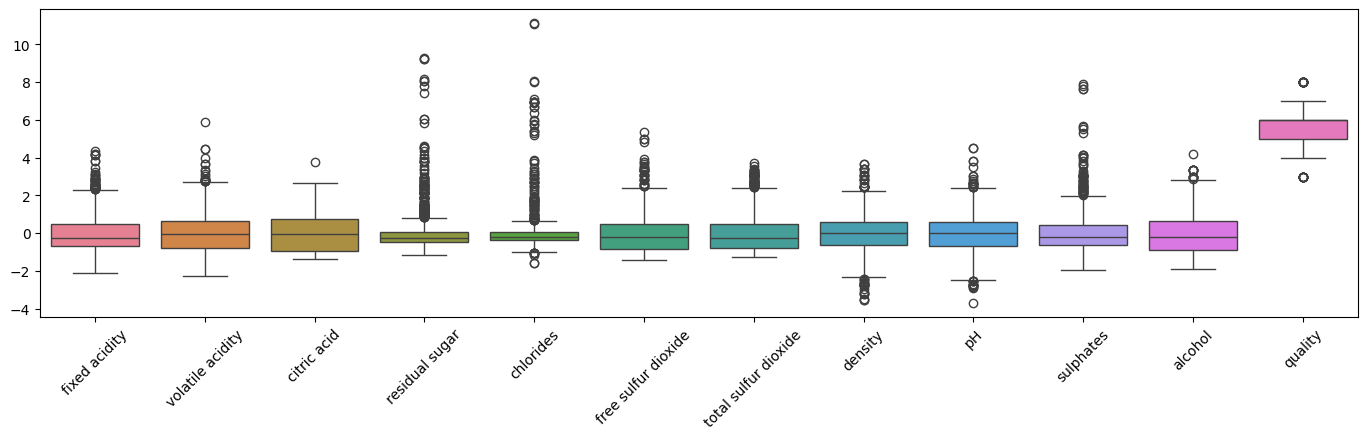

In [8]:
# check the plot again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
current_ticks = ax.get_xticks()
ax.set_xticks(current_ticks)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show();

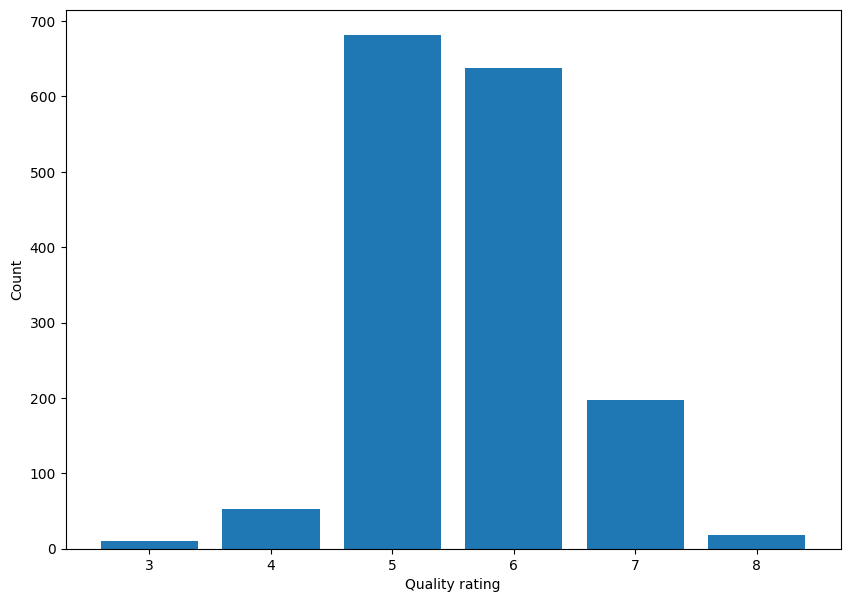

In [9]:
# distribution quality values
fig = plt.figure(figsize=(10,7))
# plt.rcParams.update({'font.size': 22}) # increase font size in the figure

counts = data['quality'].value_counts()
plt.bar(list(counts.keys()),counts)
plt.xlabel('Quality rating')
plt.ylabel('Count')
plt.show();

In [10]:
data = data.assign(boolQuality = np.where(data['quality']>5,1,0))

labels = data['boolQuality']
data = data.drop(['quality','boolQuality'],axis=1)

## **Reorganize the data into train/test data loaders**

In [11]:
testsize = 0.2
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=testsize, random_state=42)

In [12]:
## Convert the data into PyTorch datsets
train_data = TensorDataset(torch.Tensor(train_data.values).float(), torch.Tensor(train_labels.values).float())
test_data = TensorDataset(torch.Tensor(test_data.values).float(), torch.Tensor(test_labels.values).float())

In [18]:
## Convert the data into Dataloader objects with varying batch sizes (a function)
def make_loaders(batchsize):
  train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
  test_loader = DataLoader(test_data, shuffle=False, batch_size=test_data.tensors[0].shape[0]) # Changed test batch size to a fixed value

  return train_loader, test_loader

In [20]:
# create a class for the model

class createANNModel(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.Batchnorm1 = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(32,32)
    self.Batchnorm2 = nn.BatchNorm1d(32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x,BatchNorm):

    # input x (x is already normalized)
    x = F.relu( self.input(x))

    # hidden layers
    if BatchNorm:
      # hidden layers 1
      x = self.Batchnorm1(x) #Batch normalize hidden layer 1
      x = self.fc1(x)        #Apply lineraization hidden layer 1
      x = F.relu(x)          #Apply non-linear-function hidden layer 1

      # hidden layer 2
      x = self.Batchnorm2(x) #Batch normalize hidden layer 2
      x = self.fc2(x)        #pply lineraization hidden layer 2
      x = F.relu(x)          #Apply non-linear-function hidden layer 2

    else:
      # hidden layers 1
      x = self.fc1(x)        #Apply lineraization hidden layer 1
      x = F.relu(x)          #Apply non-linear-function hidden layer 1

      # hidden layer 2
      x = self.fc2(x)        #pply lineraization hidden layer 2
      x = F.relu(x)          #Apply non-linear-function hidden layer 2


    return self.output(x)

In [21]:
# train the model

def trainTheModel(batchsize, numepochs=500, lr=0.001, BatchNorm=True):
  # model, lossfun, optimizer = createANNModel(learning_rate=lr)
  model = createANNModel()

  # Move the model to the GPU if available
  model.to(device)

  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)

  train_loader, test_loader = make_loaders(batchsize)

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []

    for X, y in train_loader:
      # Move the data to the GPU if available
      X, y = X.to(device), y.to(device)

      # forward pass
      yHat = model(X,BatchNorm)

      loss = lossfun(yHat,y.reshape(-1, 1)) # Reshape y to match yHat

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch

      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
      batchLoss.append( loss.item() )
      # end of batch loop...

    # Average training accuracy and losses
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # print progress
    if (epochi+1) % 50 == 0: # Print every 50 epochs
        print(f'Epoch {epochi+1}/{numepochs}, Accuracy: {trainAcc[-1]:.4f}')


    #evaluate the model once for each epoch
    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # Move the data to the GPU if available
    X, y = X.to(device), y.to(device)

    model.eval()

    with torch.no_grad():
      yHat = model(X, BatchNorm)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # end of epoch loop

  # function output
  return model, trainAcc,testAcc,losses

In [22]:
import time

## Run the model for batch sizes of 2, 4, 8, 16, etc.
batchsizes = 2 ** np.arange(1,10, 2) # Reduced the range and number of batch sizes
# batchsizes = [128,]
batch_hist = {}   # Dictionary to store the batch performances
batch_times = {}  # Dictionary to store execution times

for batchsize in batchsizes:
  start_time = time.time()  # Start timer
  print(f"Training model with batch size: {batchsize}")
  model, trainAcc,testAcc,losses = trainTheModel(int(batchsize),numepochs=1000, lr=0.01, BatchNorm=True) # Reduced epochs
  end_time = time.time()    # End timer
  batch_hist[batchsize] = {'trainAcc': trainAcc, 'testAcc': testAcc, 'losses': losses}
  batch_times[batchsize] = end_time - start_time # Store the duration

# Print or analyze batch_times
# print("Batch size execution times:")
# for bs, duration in batch_times.items():
#     print(f"Batch size {int(bs)}: {duration:.2f} seconds")

Training model with batch size: 2
Epoch 50/1000, Accuracy: 50.4133
Epoch 100/1000, Accuracy: 50.5545
Epoch 150/1000, Accuracy: 50.3414
Epoch 200/1000, Accuracy: 50.2310
Epoch 250/1000, Accuracy: 50.4666
Epoch 300/1000, Accuracy: 50.5694
Epoch 350/1000, Accuracy: 50.6074
Epoch 400/1000, Accuracy: 50.7458
Epoch 450/1000, Accuracy: 50.8471
Epoch 500/1000, Accuracy: 50.5983
Epoch 550/1000, Accuracy: 50.8619
Epoch 600/1000, Accuracy: 50.8362
Epoch 650/1000, Accuracy: 50.6759
Epoch 700/1000, Accuracy: 50.7759
Epoch 750/1000, Accuracy: 51.6132
Epoch 800/1000, Accuracy: 51.0377
Epoch 850/1000, Accuracy: 51.0356
Epoch 900/1000, Accuracy: 50.8772
Epoch 950/1000, Accuracy: 51.3789
Epoch 1000/1000, Accuracy: 51.0201
Training model with batch size: 8
Epoch 50/1000, Accuracy: 50.3157
Epoch 100/1000, Accuracy: 50.5237
Epoch 150/1000, Accuracy: 50.5571
Epoch 200/1000, Accuracy: 50.7025
Epoch 250/1000, Accuracy: 50.6562
Epoch 300/1000, Accuracy: 50.7808
Epoch 350/1000, Accuracy: 50.8239
Epoch 400/1000,

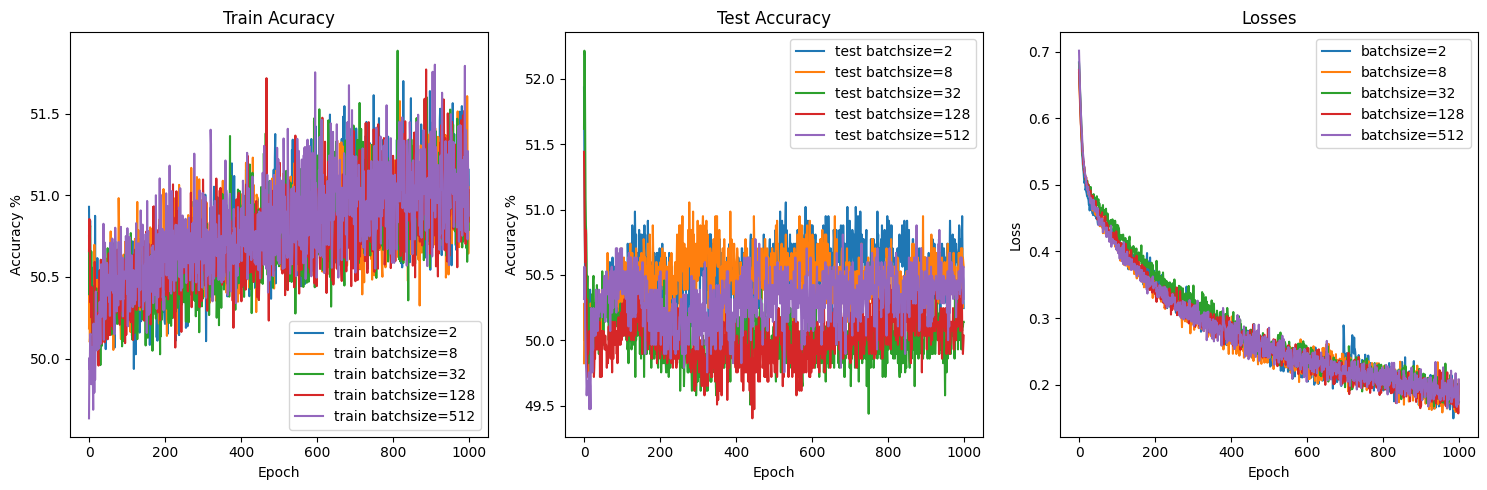

In [23]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(15,5))

batchsizes_values = [bs for bs in batchsizes]

for i, bs in enumerate(batchsizes):
  bs_val = batchsizes_values[i]
  ax[0].plot(batch_hist[bs]['trainAcc'],label=f'train batchsize={np.round(bs_val,2)}')
  ax[1].plot(batch_hist[bs]['testAcc'],label=f'test batchsize={np.round(bs_val,2)}')
  ax[2].plot(batch_hist[bs]['losses'],label=f'batchsize={np.round(bs_val,2)}')

ax[0].set_title('Train Acuracy')
ax[1].set_title('Test Accuracy')
ax[2].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[2].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy %')
ax[1].set_ylabel('Accuracy %')
ax[2].set_ylabel('Loss')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()
plt.show();